In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns

D:\Installed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
D:\Installed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
z = (train['demand'].count() - train['demand'].mean()) / train['demand'].std()
z

436.0232680395623

In [5]:
df = train.copy()
df

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81
...,...,...,...
18242,2021-02-28,19,95
18243,2021-02-28,20,88
18244,2021-02-28,21,39
18245,2021-02-28,22,104


In [6]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].apply(lambda x: x.year)
df

,date,hour,demand,year
0,2018-08-18,9,91,2018
1,2018-08-18,10,21,2018
2,2018-08-18,13,23,2018
3,2018-08-18,14,104,2018
4,2018-08-18,15,81,2018
...,...,...,...,...
18242,2021-02-28,19,95,2021
18243,2021-02-28,20,88,2021
18244,2021-02-28,21,39,2021
18245,2021-02-28,22,104,2021


In [7]:
# Extract date feature
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].apply(lambda x: x.year) #because model wont have experience past 2017 cause year has (2015-2017)
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df['day_of_week'] = df['date'].apply(lambda x: x.dayofweek)
df['is_quarter_date'] = df['date'].apply(lambda x: x.quarter)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x>4 else 0)

df.drop(['date'], axis=1, inplace=True)
df

,hour,demand,year,month,day,day_of_week,is_quarter_date,is_weekend
0,9,91,2018,8,18,5,3,1
1,10,21,2018,8,18,5,3,1
2,13,23,2018,8,18,5,3,1
3,14,104,2018,8,18,5,3,1
4,15,81,2018,8,18,5,3,1
...,...,...,...,...,...,...,...,...
18242,19,95,2021,2,28,6,1,1
18243,20,88,2021,2,28,6,1,1
18244,21,39,2021,2,28,6,1,1
18245,22,104,2021,2,28,6,1,1


In [8]:
# Extract date feature for test
test['date'] = pd.to_datetime(test['date'])
# test['year'] = test['date'].apply(lambda x: x.year) #because model wont have experience past 2017 cause year has (2015-2017)
test['month'] = test['date'].apply(lambda x: x.month)
test['day'] = test['date'].apply(lambda x: x.day)
test['day_of_week'] = test['date'].apply(lambda x: x.dayofweek)
# test['is_quarter_date'] = test['date'].apply(lambda x: x.quarter)
test['is_weekend'] = test['day_of_week'].apply(lambda x: 1 if x>4 else 0)

test.drop(['date'], axis=1, inplace=True)

In [9]:
test

,hour,month,day,day_of_week,is_weekend
0,0,3,1,0,0
1,1,3,1,0,0
2,2,3,1,0,0
3,3,3,1,0,0
4,5,3,1,0,0
...,...,...,...,...,...
7645,19,3,28,0,0
7646,20,3,28,0,0
7647,21,3,28,0,0
7648,22,3,28,0,0


In [10]:
#creating function to identify time of day: morning, afternoon, evening, night, etc.
def time_of_day(n):
    if n in range(4,8):
        return 'Early Morning'
    elif n in range(8,12):
        return 'Morning'
    elif n in range(12,18):
        return 'Afternoon'
    elif n in range(18,21):
        return 'Evening'
    elif n in range(21,25) or n==0:
        return 'Night'
    elif n in range(1,4):
        return 'Late Night'
    
df['Type_of_Day'] = df['hour'].apply(lambda x: time_of_day(x))
df

,hour,demand,year,month,day,day_of_week,is_quarter_date,is_weekend,Type_of_Day
0,9,91,2018,8,18,5,3,1,Morning
1,10,21,2018,8,18,5,3,1,Morning
2,13,23,2018,8,18,5,3,1,Afternoon
3,14,104,2018,8,18,5,3,1,Afternoon
4,15,81,2018,8,18,5,3,1,Afternoon
...,...,...,...,...,...,...,...,...,...
18242,19,95,2021,2,28,6,1,1,Evening
18243,20,88,2021,2,28,6,1,1,Evening
18244,21,39,2021,2,28,6,1,1,Night
18245,22,104,2021,2,28,6,1,1,Night


In [11]:
test['Type_of_Day'] = test['hour'].apply(lambda x: time_of_day(x))

In [12]:
def month2seasons(x):
    if x in [9, 10, 11]:
        season = 'Spring'
    elif x in [12, 1, 2]:
        season = 'Summer'
    elif x in [3, 4, 5]:
        season = 'Autumn'
    elif x in [6, 7, 8]:
        season = 'Winter'
    return season

df['Season'] = df['month'].apply(month2seasons)

In [13]:
test['Season'] = test['month'].apply(month2seasons)

In [14]:
df['Type_of_Day'].replace({'Afternoon': 0, 'Morning' : 1, 'Night':2, 'Evening':3, 'Early Morning':4, 'Late Night':5}, 
                          inplace=True)
df['Season'].replace({'Spring':0, 'Summer':1, 'Autumn':2, 'Winter':3}, inplace=True)

In [15]:
test['Type_of_Day'].replace({'Afternoon': 0, 'Morning' : 1, 'Night':2, 'Evening':3, 'Early Morning':4, 'Late Night':5}, 
                          inplace=True)
test['Season'].replace({'Spring':0, 'Summer':1, 'Autumn':2, 'Winter':3}, inplace=True)

<AxesSubplot:xlabel='hour', ylabel='demand'>

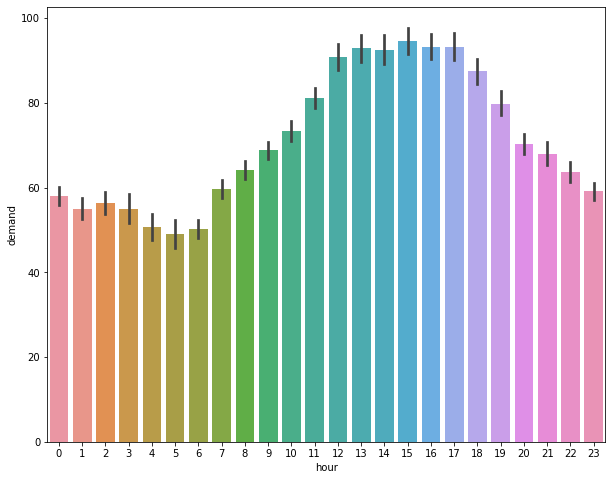

In [16]:
plt.figure(figsize=(10,8))
sns.barplot(x=df['hour'], y=df['demand'])

In [17]:
#split df into X & y
y = df['demand'].copy()
X = df.drop('demand', axis=1).copy()

In [18]:
# Feature engineering of hour of month like cyclical feature & days in week feature
X['hour_sin'] = np.sin(X['hour']*(2.*np.pi/24))
X['hour_cos'] = np.cos(X['hour']*(2.*np.pi/24))
X['month_sin'] = np.sin((X['month']-1)*(2.*np.pi/12))
X['month_cos'] = np.cos((X['month']-1)*(2.*np.pi/12))

X['day_of_week'] = np.cos(X['day_of_week'])

X.drop(['hour', 'month'], axis=1, inplace=True)